## SHOTCRETE DESIGN - SPANNING BETWEEN BOLTS IN SANDSTONE

Prepared by: Nick Mirsepassi

Revision = 0


date = 20/08/2025

### Aim
To determine the required shotcrete design to resist failure mechanisms such as adhesion loss, direct shear, flexure, and punching shear failure under a particular rockbolt design layout.

---

### Methodology
This calculation refers to the Barrett and McCreath method as defined in [Ref 2] that characterises the principal collapse mechanisms for a shotcrete support in rock. The methodology considers the shotcrete shell as a plate and the rock bolts as vertical restraints. Therefore, the shotcrete shell is divided into sets of rectangular panels and loaded by the weight of rock wedges resulting in the potential failure mechanisms mentioned above. Figure 1 shows an illustration of said loading mechanism. The calculation also references Vandewalle (2001 & 2005) for the formulation of shotcrete properties as described in [Ref 3] and [Ref 4].

---

### References
- **Ref 1** – DJV-045-GT2 REV 1  
- **Ref 2** – Barrett, S.V.L & McCreath, D.R (1995), *Shotcrete Support Design in Blocky Ground: Towards a Deterministic Approach*  
- **Ref 3** – Vandewalle, M (2001), *Tunnelling the World*, Seventh Edition, p.130  
- **Ref 4** – Vandewalle, M (2005), *Tunnelling is an Art; Dramix Steel Fibre at Bekaert*, p.129  
- **Ref 5** – Bertuzzi, R. & Pells, P.J.N. (2002), *Shotcrete Design for Rock Support in Tunnels: Punching and Flexural Behaviour*, Australian Tunnelling Conference Proceedings  
- **Ref 6** – EFNARC (1996), *Specification for Sprayed Concrete* – guidelines on sprayed concrete design and testing  
- **Ref 7** – ITA Working Group 12 (2000), *Guidelines on Sprayed Concrete for Rock Support* – International Tunnelling Association  


---

### Wedge Load
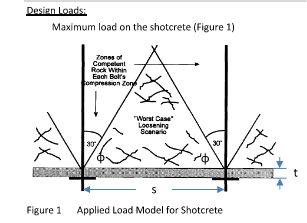

---

### Overbreak Load
Alternatively used for a defined overbreak (block height)


In [1]:
# PYTHON IMPORTS
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Inputs

This notebook uses the following inputs (units in **SI**):

### Rock / Load
- **`gamma_kN_m3`** — unit weight of rock, $\gamma$ \[kN/m³\].  
  Used to compute the panel load $W$.
- **`load_model`** — selects how $W$ is calculated:
  - `"wedge"` → Barrett–McCreath wedge load: $W=\gamma\frac{\sqrt{6}\,s^3}{6}$.
  - `"overbreak"` → slab/overbreak load: $W=\gamma\,h\,s^2$ (requires `overbreak_m`).
- **`overbreak_m`** — loosened rock thickness $h$ \[m\]. **Only** used when `load_model="overbreak"`.
- **`LF`** — load factor applied to $W$ (i.e., $W_f=LF\cdot W$).

### Geometry
- **`s0_m`** — bolt spacing $s_0$ \[m\] used for the **summary table** (the plot sweeps a range separately).
- **`t_m`** — shotcrete thickness $t$ \[m\].
- **`c_m`** — bearing plate (or effective support width) $c$ \[m\]; appears in flexural demand and punching.
- **`m_f`** — **flexural connection factor** (see note below); reduces/enhances moment demand depending on connection stiffness.

### Adhesion (two cases are checked)
- **`sigma_a_poor_MPa`**, **`a_poor_m`** — adhesion strength $\sigma_a$ \[MPa\] and bond length $a$ \[m\] for a **poor** adhesion assumption.  
- **`sigma_a_good_MPa`**, **`a_good_m`** — adhesion strength and bond length for a **good** adhesion assumption.  
Adhesion capacity is $C_a=4\,\sigma_a\,s\,a$.

### Material properties & factors
- **`f_c_MPa`** — compressive strength $f_c$ \[MPa\] (28-day or design value).  
  Used to derive:
  - Flexural design strength $\sigma_{fl}=\min\!\big(0.6\sqrt{f_c},\,f_{eq}\big)$,
  - Direct shear $\tau_{ds}=0.15\,f_c^{1/3}+\dfrac{0.12\,k_f\,k_d\,f_{eq}}{0.37}$,
  - Punching stress $\sigma_{ps}=\min\!\big[(0.17+0.17\beta_h),\,0.34\big]\,f_c$.
- **`beta_h`** — punching factor $\beta_h$ (typically $1.0$); influences $\sigma_{ps}$.
- **`k_f`** — fibre efficiency factor for the shear contribution term (dimensionless).
- **`k_d`** — depth/thickness factor for the shear contribution term (dimensionless).
- **`f_eq_MPa`** — residual/equivalent flexural strength from beam tests \[MPa\]; caps $\sigma_{fl}$ and feeds the shear fibre term.

### Plot sweep (for FoS vs spacing figure)
- **`s_min`**, **`s_max`** — minimum/maximum bolt spacing \[m\] for the plot.
- **`n_pts`** — number of points between `s_min` and `s_max`.

---

### Note on Flexural Connection Factor ($m_f$)
The factor $m_f$ accounts for the degree of rotational restraint provided by rock bolts and bearing plates at the shotcrete interface. Perfect fixity at the bolt face is rarely achieved; the connection lies between pinned and fully fixed. Laboratory and field tests have shown that using a reduced moment factor provides better agreement with observed behaviour.

Typical values are:  
- $m_f \approx 0.14$ → very flexible / pinned connection  
- $m_f \approx 0.65$ → fully fixed connection  
- $m_f \approx 0.40\text{–}0.45$ → intermediate values often adopted

Selection of $m_f$ should reflect the plate/washer type, bond conditions, and calibration to project experience.


In [2]:
# ----------------------------
# INPUTS
# ----------------------------
p = dict(
    # Rock / load
    gamma_kN_m3 = 24.0,         # unit weight of rock [kN/m³]
    load_model  = "wedge",      # "wedge" -> W = γ*sqrt(6)*s^3/6  (Barrett–McCreath)
    overbreak_m = 0.035,        # only used if load_model="overbreak"
    LF = 1.0,                   # load factor on W

    # Geometry
    s0_m = 1.0,                 # spacing for summary table [m]
    t_m  = 0.10,                # shotcrete thickness [m]
    c_m  = 0.15,                # plate width [m] (for flexural demand)
    m_f  = 0.4,                 # flexural connection factor

    # Adhesion — BOTH cases
    sigma_a_poor_MPa = 0.1,     # interface adhesion (poor) [MPa]
    a_poor_m = 0.03,            # bond length (poor) [m]
    sigma_a_good_MPa = 0.5,     # interface adhesion (good) [MPa]
    a_good_m = 0.05,            # bond length (good) [m]

    # Material: compressive strength basis + factors
    f_c_MPa = 40.0,             # compressive strength [MPa] - 28 days considered
    beta_h = 1.0,               # punching factor
    k_f = 1.0, k_d = 1.0,       # fibre & depth factors
    f_eq_MPa = 2.0,             # residual flexural

    # Plot sweep
    s_min = 0.5, s_max = 4.0, n_pts = 60
)



### Derived Material Properties

The following empirical relationships are used to derive shotcrete material strengths from the input compressive strength $f_c$ (with beam-test data $f_{eq}$ used where available):

- **Flexural strength** ($\sigma_{fl}$)

  $$\sigma_{fl} = \min\!\big(0.6\,\sqrt{f_c},\; f_{eq}\big)$$

  This caps the empirical estimate $0.6\sqrt{f_c}$ by the residual/equivalent flexural strength measured in beam tests ($f_{eq}$).  
  *Example:* if $f_c = 25\,\text{MPa}$ and $f_{eq}=2.5\,\text{MPa}$, then $\sigma_{fl}=2.5\,\text{MPa}$.

- **Direct shear strength** ($\tau_{ds}$)

  $$\tau_{ds} = 0.15\,f_c^{1/3} \;+\; \frac{0.12\,k_f\,k_d\,f_{eq}}{0.37}$$

  This combines a compressive-strength term with a fibre contribution term:
  - $k_f$: fibre factor (fibre efficiency)  
  - $k_d$: depth/thickness factor  
  - $f_{eq}$: residual/equivalent flexural strength from beam tests  

- **Punching shear capacity stress** ($\sigma_{ps}$)

  $$\sigma_{ps} = \min\!\big[(0.17 + 0.17\,\beta_h),\,0.34\big]\; f_c$$

  This limits the punching shear stress to between $0.17\,f_c$ and $0.34\,f_c$, depending on $\beta_h$ (typically $\beta_h = 1.0$).



In [3]:
# ----------------------------
# DERIVED MATERIAL PROPERTIES (from f_c)
# ----------------------------
# DERIVED MATERIAL PROPERTIES (from f_c and optionally f_eq)
sigma_fl_MPa_est = 0.6 * math.sqrt(p["f_c_MPa"])          # estimate from f_c
sigma_fl_MPa     = min(sigma_fl_MPa_est, p["f_eq_MPa"])   # <- clamp to beam-test f_eq when available

tau_ds_MPa   = 0.15 * (p["f_c_MPa"] ** (1/3)) + (0.12 * p["k_f"] * p["k_d"] * p["f_eq_MPa"]) / 0.37
sigma_ps_MPa = min((0.17 + 0.17*p["beta_h"]), 0.34) * p["f_c_MPa"]



### Helper Functions

The following functions implement the Barrett & McCreath (1995) shotcrete panel design checks, with two options for punching capacity (simplified and equilibrium-based):

- **`rock_load_kN(s, P)`**  
  Calculates the applied rock load $W$ on the shotcrete panel.  
  - If `load_model="overbreak"`:  
    $$W = \gamma \cdot h \cdot s^2$$  
    where $h$ is the loosened rock thickness.  
  - If `load_model="wedge"`:  
    $$W = \gamma \cdot \frac{\sqrt{6}\,s^3}{6}$$  
    the Barrett–McCreath wedge block formula.

- **`adhesion_capacity_kN(s, \sigma_a, a_m)`**  
  Computes adhesion resistance:  
    $$C_a = 4 \cdot \sigma_a \cdot s \cdot a$$  
  where $\sigma_a$ is adhesion strength and $a$ is the adhesion bond length.

- **`direct_shear_capacity_kN(s, P, \tau_{ds})`**  
  Computes direct shear capacity:  
    $$C_{ds} = 4 \cdot \tau_{ds} \cdot s \cdot t$$  
  where $\tau_{ds}$ is direct shear strength and $t$ is shotcrete thickness.

- **`flexural_capacity_kNm(s, P, \sigma_{fl})`**  
  Flexural bending capacity of a panel strip:  
    $$C_{fl} = \sigma_{fl} \cdot \frac{t^2}{6} \cdot \frac{s}{2}$$  
  where $\sigma_{fl}$ is flexural strength.

- **`flexural_demand_kNm(s, P, W)`**  
  Calculates the design bending moment demand:  
    $$M = \frac{W \cdot s}{8}\left(\frac{s-c}{s}\right)^2 \cdot m_f$$  
  where $c$ is the plate width and $m_f$ the flexural connection factor.

- **`punching_capacity_kN(P, \sigma_{ps})`**  
  Simplified punching shear capacity (assumes $d \approx t$):  
    $$C_{ps} = \sigma_{ps} \cdot 4(c+t) \cdot t$$  
  where $\sigma_{ps}$ is punching shear stress capacity.

- **Equilibrium-based punching helpers**  
  A more detailed punching shear calculation using load equilibrium:  
  - Shear at perimeter:  
    $$V = W \cdot \left(1 - \left(\tfrac{c}{s}\right)^2\right)$$  
  - Shear perimeter extension:  
    $$d = \sqrt{\left(\tfrac{c}{4}\right)^2 + \frac{V}{4\,\sigma_{ds}}} - \tfrac{c}{4}$$  
    with $\sigma_{ds} \approx 0.4 f_c$  
  - Punching capacity:  
    $$C_{ps} = \sigma_{ps} \cdot 4(c+d) \cdot t$$  

- **`fos(cap, dem)`**  
  Factor of safety calculation:  
    $$FoS = \frac{\text{Capacity}}{\text{Demand}}$$

- **`pf(x)`**  
  Pass/Fail check: returns `"PASS"` if $FoS \geq 1.0$, otherwise `"FAIL"`.


In [4]:
# ----------------------------
# HELPERS
# ----------------------------
def rock_load_kN(s, P):
    if P["load_model"].lower() == "overbreak":
        return P["gamma_kN_m3"] * P["overbreak_m"] * s**2
    return P["gamma_kN_m3"] * math.sqrt(6.0) * s**3 / 6.0

def adhesion_capacity_kN(s, sigma_a_MPa, a_m):
    return 4.0 * sigma_a_MPa * 1000.0 * s * a_m  # MPa→kN/m²

def direct_shear_capacity_kN(s, P, tau_ds):
    return 4.0 * tau_ds * 1000.0 * s * P["t_m"]

def flexural_capacity_kNm(s, P, sigma_fl):
    return sigma_fl * 1000.0 * (P["t_m"]**2)/6.0 * (s/2.0)

def flexural_demand_kNm(s, P, W_kN):
    return (P["LF"]*W_kN) * s / 8.0 * ((s - P["c_m"])/s)**2 * P["m_f"]

def punching_capacity_kN(P, sigma_ps):
    d = P["t_m"]  # simple conservative take
    return sigma_ps * 1000.0 * 4.0 * (P["c_m"] + d) * P["t_m"]

def fos(cap, dem): return cap/dem if dem>0 else float("inf")

def pf(x): return "PASS" if x>=1.0 else "FAIL"

# --- Annexure punching helpers ---
def V_shear_kN(W_kN, s_m, c_m):
    """Shear at the punching perimeter per Annexure: V = W * (1 - (c/s)^2)."""
    return W_kN * (1.0 - (c_m / s_m)**2)

def d_from_equilibrium_m(W_kN, s_m, c_m, sigma_ds_MPa):
    """
    Annexure: d = sqrt((c/4)^2 + V/(4*sigma_ds)) - c/4
    Units: W in kN, sigma_ds in MPa (= kN/mm^2 * 1000). The division by 1000 below keeps units consistent in meters.
    """
    V = V_shear_kN(W_kN, s_m, c_m)                 # kN
    return math.sqrt((c_m/4.0)**2 + (V/1000.0)/(4.0*sigma_ds_MPa)) - c_m/4.0

def punching_capacity_annexure_kN(P, sigma_ps_MPa, W_kN, s_m):
    """
    C_ps = sigma_ps * 4 * (c + d) * t     with d from equilibrium (above).
    sigma_ds is taken as ~0.4 * f_c per Annexure notes.
    """
    sigma_ds_MPa = 0.4 * P["f_c_MPa"]            # Annexure take
    d_m = d_from_equilibrium_m(W_kN, s_m, P["c_m"], sigma_ds_MPa)
    return sigma_ps_MPa * 1000.0 * 4.0 * (P["c_m"] + d_m) * P["t_m"], d_m

### Summary Table at $s_0$

At a selected bolt spacing $s_0$, the capacities, demands, and factors of safety are calculated for each failure mechanism:

- **Applied load**  
  $$W = \text{rock\_load}(s_0)$$  
  The design load at spacing $s_0$ (factored by $LF$ as $W_f = LF \cdot W$).

- **Adhesion (poor and good cases)**  
  $$C_a = 4 \cdot \sigma_a \cdot s_0 \cdot a$$  
  Two cases are checked:  
  - *Poor adhesion*: $\sigma_a = 0.1$ MPa, $a = 0.03$ m  
  - *Good adhesion*: $\sigma_a = 0.5$ MPa, $a = 0.05$ m

- **Direct shear**  
  $$C_{ds} = 4 \cdot \tau_{ds} \cdot s_0 \cdot t$$  
  where $\tau_{ds}$ is the direct shear strength and $t$ the shotcrete thickness.

- **Flexure**  
  Capacity:  
  $$C_{fl} = \sigma_{fl} \cdot \frac{t^2}{6} \cdot \frac{s_0}{2}$$  
  with $\sigma_{fl} = \min(0.6\sqrt{f_c}, f_{eq})$  
  Demand:  
  $$M_d = \frac{W \cdot s_0}{8}\left(\frac{s_0 - c}{s_0}\right)^2 \cdot m_f$$  
  where $c$ is the plate width and $m_f$ the flexural connection factor.

- **Punching shear (equilibrium-based)**  
  First compute shear:  
  $$V = W \cdot \left(1 - \left(\tfrac{c}{s_0}\right)^2\right)$$  
  Then shear perimeter extension:  
  $$d = \sqrt{\left(\tfrac{c}{4}\right)^2 + \frac{V}{4 \sigma_{ds}}} - \tfrac{c}{4}$$  
  with $\sigma_{ds} \approx 0.4 f_c$  
  Finally, punching capacity:  
  $$C_{ps} = \sigma_{ps} \cdot 4(c+d) \cdot t$$  
  where $\sigma_{ps}$ is the punching shear stress capacity.

- **Factor of Safety**  
  $$FoS = \frac{\text{Capacity}}{\text{Demand}}$$  
  A mechanism is marked as **PASS** if $FoS \geq 1.0$, otherwise **FAIL**.

---

**Table Output**  
The code prints the derived strengths (from $f_c$ and $f_{eq}$), the applied load $W$, the flexural moment demand $M_d$, and displays a summary table with:

- *Check* → failure mode considered  
- *Capacity* (kN or kN·m)  
- *Demand* (kN or kN·m)  
- *FoS* → factor of safety  
- *Status* → PASS/FAIL


In [5]:
# ----------------------------
# SUMMARY TABLE at s0 (includes BOTH adhesion cases)
# Using: σ_fl = min(0.6√f_c, f_eq) and Annexure punching (equilibrium-based d)
# ----------------------------
s0  = p["s0_m"]
W0  = rock_load_kN(s0, p)
W0f = p["LF"] * W0

# Capacities (adhesion: poor & good)
Ca_poor = adhesion_capacity_kN(s0, p["sigma_a_poor_MPa"], p["a_poor_m"])
Ca_good = adhesion_capacity_kN(s0, p["sigma_a_good_MPa"], p["a_good_m"])

# Direct shear capacity
Cds = direct_shear_capacity_kN(s0, p, tau_ds_MPa)

# Flexural: capacity vs demand
Cfl = flexural_capacity_kNm(s0, p, sigma_fl_MPa)
Md  = flexural_demand_kNm(s0, p, W0)

# Punching (Annexure): capacity and d from equilibrium
Cps, d_m = punching_capacity_annexure_kN(p, sigma_ps_MPa, W0, s0)

summary = pd.DataFrame([
    ["Adhesion (poor)", Ca_poor, W0f, fos(Ca_poor, W0f), pf(fos(Ca_poor, W0f))],
    ["Adhesion (good)", Ca_good, W0f, fos(Ca_good, W0f), pf(fos(Ca_good, W0f))],
    ["Direct Shear",    Cds,     W0f, fos(Cds,    W0f), pf(fos(Cds,    W0f))],
    ["Flexure",         Cfl,     Md,  fos(Cfl,    Md),  pf(fos(Cfl,    Md))],
    ["Punching",        Cps,     W0f, fos(Cps,    W0f), pf(fos(Cps,    W0f))],
], columns=["Check","Capacity (kN or kN·m)","Demand (kN or kN·m)","FoS [-]","Status"])

print(f"Derived strengths from f_c={p['f_c_MPa']} MPa  →  σ_fl={sigma_fl_MPa:.2f} MPa, τ_ds={tau_ds_MPa:.2f} MPa, σ_ps={sigma_ps_MPa:.2f} MPa")
print(f"Spacing s0 = {s0:.2f} m | Load model = {p['load_model']} | W = {W0:.2f} kN | M_demand = {Md:.2f} kN·m")
print(f"Annexure punching: d = {d_m:.3f} m\n")

display(
    summary.style.format({
        "Capacity (kN or kN·m)": "{:.2f}",
        "Demand (kN or kN·m)": "{:.2f}",
        "FoS [-]": "{:.2f}"
    })
)


Derived strengths from f_c=40.0 MPa  →  σ_fl=2.00 MPa, τ_ds=1.16 MPa, σ_ps=13.60 MPa
Spacing s0 = 1.00 m | Load model = wedge | W = 9.80 kN | M_demand = 0.35 kN·m
Annexure punching: d = 0.002 m



,Check,Capacity (kN or kN·m),Demand (kN or kN·m),FoS [-],Status
0,Adhesion (poor),12.00,9.80,1.22,PASS
1,Adhesion (good),100.00,9.80,10.21,PASS
2,Direct Shear,464.66,9.80,47.42,PASS
3,Flexure,1.67,0.35,4.71,PASS
4,Punching,826.58,9.80,84.36,PASS


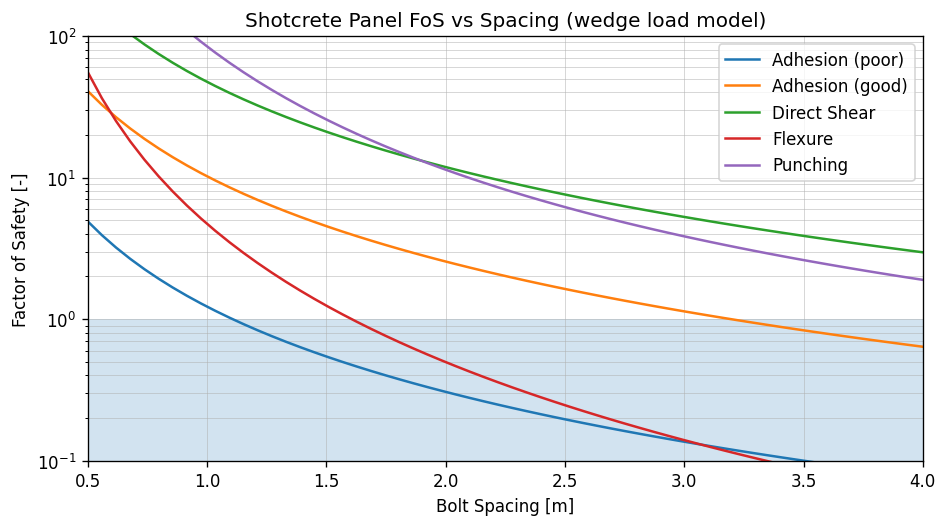

In [6]:
# ----------------------------
# PLOT: FoS vs Spacing (shows BOTH adhesion curves)
# ----------------------------
s_vals = np.linspace(p["s_min"], p["s_max"], p["n_pts"])
fos_adh_poor, fos_adh_good, fos_ds, fos_fl, fos_ps = [], [], [], [], []

for s in s_vals:
    W  = rock_load_kN(s, p)
    Wf = p["LF"] * W

    Ca_p = adhesion_capacity_kN(s, p["sigma_a_poor_MPa"], p["a_poor_m"])
    Ca_g = adhesion_capacity_kN(s, p["sigma_a_good_MPa"], p["a_good_m"])
    Cds  = direct_shear_capacity_kN(s, p, tau_ds_MPa)
    Cfl  = flexural_capacity_kNm(s, p, sigma_fl_MPa)
    Md   = flexural_demand_kNm(s, p, W)

    # Annexure punching (equilibrium-based d)
    Cps, _ = punching_capacity_annexure_kN(p, sigma_ps_MPa, W, s)

    fos_adh_poor.append(Ca_p / Wf)
    fos_adh_good.append(Ca_g / Wf)
    fos_ds.append(Cds / Wf)
    fos_fl.append(Cfl / Md if Md > 0 else np.nan)
    fos_ps.append(Cps / Wf)

plt.figure(figsize=(8,4.5), dpi=120)
plt.plot(s_vals, fos_adh_poor, label="Adhesion (poor)")
plt.plot(s_vals, fos_adh_good, label="Adhesion (good)")
plt.plot(s_vals, fos_ds,  label="Direct Shear")
plt.plot(s_vals, fos_fl,  label="Flexure")
plt.plot(s_vals, fos_ps,  label="Punching")
plt.fill_between(s_vals, 0.0, 1.0, alpha=0.2)  # FoS < 1 region
plt.yscale("log"); plt.ylim(0.1, 100); plt.xlim(s_vals.min(), s_vals.max())
plt.grid(True, which="both", alpha=0.6, linewidth=0.5)
plt.xlabel("Bolt Spacing [m]"); plt.ylabel("Factor of Safety [-]")
title_suffix = "(wedge load model)" if p["load_model"].lower()=="wedge" else f"(overbreak h={p['overbreak_m']:.3f} m)"
plt.title(f"Shotcrete Panel FoS vs Spacing {title_suffix}")
plt.legend(); plt.tight_layout(); plt.show()

